# Verifying Hybrid Graphs
This notebook investigates the structure of various SNAP graphs to determine whether their communities are small-world and whether the structure of communities is scale-free. Note: community detection is non-deterministic so the results may very each time you run this notebook.

In [1]:
import networkit as nk
from networkit.graphio import SNAPGraphReader as SNAP
from networkit.viztasks import drawGraph
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from math import ceil

def file_to_graph(filename):
    graph = SNAP().read(filename)
    if graph.isDirected(): graph = graph.toUndirected().removeSelfLoops()
    return graph

The following data sources are available:

* **Facebook**: an ego network of Facebook users connected by friendships.
* **LiveJournal**: an ego network connecting LiveJournal users to their friends.
* **Epinions**: an ego network of trust between Epinions users.
* **Twitter**: an ego network of who users follow.

In [2]:
# Dear my laptop, I'm very sorry for what you're about to load into memory.
facebook = file_to_graph("data/facebook_combined.txt")
livejournal = file_to_graph("data/com-lj.ungraph.txt")
epinions = file_to_graph("data/soc-Epinions1.txt")
twitter = file_to_graph("data/twitter_combined.txt")

In [3]:
def get_C(graph, turbo=True):
    # If graphs get too large, turn off Turbo mode (which requires more memory)
    lcc = nk.centrality.LocalClusteringCoefficient(graph, turbo)
    lcc.run()
    scores = lcc.scores()
    return sum(scores) / len(scores)

def get_L(graph):
    apsp = nk.distance.APSP(graph)
    apsp.run()
    n = graph.numberOfNodes()
    if n == 1: return 0
    total_distance = 0
    for i in graph.iterNodes():
        for j in graph.iterNodes():
            if i > j:
                total_distance += apsp.getDistance(i, j)
    return total_distance / (n * (n - 1))

def generate_similar_random(graph):
    # Generate a random graph with a similar number of edges.
    # In Collective Dynamics of Small World Networks (Watts and Strogatz, 1998),
    # they use WattsStrogatz with the same n and k as a given graph, and with p=1.
    # Note that in NetworKit, k is the number of neighbours on _each_ side,
    # so we set it to half of the average degree.
    n = graph.numberOfNodes()
    if n <= 1: return nk.graph.Graph(1)
    degrees = [graph.degree(n) for n in graph.iterNodes()]
    k = sum(degrees) / (2 * n)
    if 2*k >= n-1: k = (n-2)/2
    return nk.generators.WattsStrogatzGenerator(n, k, 1).generate()

def normalised_subgraph(graph, partition):
    # APSP requires the nodes to be contiguous.
    # When you take a subgraph, they aren't contiguous.
    # Thus we make them contiguous.
    subgraph = nk.graphtools.subgraphFromNodes(graph, partition)
    node_remap = nk.graphtools.getContinuousNodeIds(subgraph)
    return nk.graphtools.getCompactedGraph(subgraph, node_remap)

def degree_plot(graph):
    degrees = [graph.degree(n) for n in graph.iterNodes()]
    degree_counts = Counter(degrees)
    x_data = []
    y_data = []
    print(degree_counts)
    for key in sorted(degree_counts.keys()):
        if key < 200:
            x_data.append(key)
            y_data.append(degree_counts[key])
    plt.scatter(x_data, y_data)
    #plt.yscale('log')
    plt.title("Degree distribution")
    plt.xlabel("Degree")
    plt.ylabel("Node Count")
    plt.show()

def extract_communities(graph, gamma, show_communities=True):
    # Generate a partition of nodes representing each community.
    part = nk.community.detectCommunities(graph, nk.community.PLM(graph, refine=False, gamma=gamma))
    comm_graph = nk.community.communityGraph(graph, part)
    print("Community Graph")
    drawGraph(comm_graph)
    plt.show()
    # For Scale Free graphs, their degree distribution must follow a power law.
    degree_plot(comm_graph)
    # Then, for each partition, display the subgraph.
    # We do this by generating node sets per partition, and then taking the induced subgraph.
    sub_ids = part.getSubsetIds()
    count = 1
    if show_communities:
        plt.figure(figsize=(10,30))
    for sub_id in sub_ids:
        members = part.getMembers(sub_id)
        G = normalised_subgraph(graph, members)
        G_random = generate_similar_random(G)
        print("Community", sub_id)
        if show_communities:
            plt.subplot(ceil(len(sub_ids)/2), 2, count)
            drawGraph(G)
            plt.title("Community "+str(sub_id))
        # Work out if each community fits the Small World Phenomenon!
        # (L <= L_r, C >> C_r)
        L = get_L(G)
        L_random = get_L(G_random)
        print("L <= L_random?", L, "<=", L_random)
        # No turbo because the graphs are actually too big, oh no.
        C = get_C(G, False)
        C_random = get_C(G_random, False)
        print("C >> C_random?", C, ">>", C_random)
        count += 1
    if show_communities:
        plt.show()

Just run `extract_communities(graph, gamma, show_communities)` to get the following information.

* The communities found with community detection `PLM(graph, refine=False, gamma=gamma)`.
* The degree distribution of the community graph (used to verify whether the community structure is scale-free). In scale-free structures, this follows a power law.
* Each community within the graph (if `show_communities` is True).
* The measures $L$, $L_{random}$, $C$ and $C_{random}$. These represent the average path length in the community, the average path length in a random graph with the same node and edge counts, the clustering coefficient of the community, and the clustering coefficient of the same random graph respectively.

PLM(balanced,pc,turbo) detected communities in 0.011643648147583008 [s]
solution properties:
-------------------  ----------
# communities         15
min community size    19
max community size   548
avg. community size  269.267
modularity             0.834968
-------------------  ----------
Community Graph


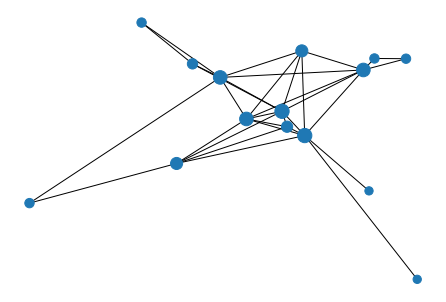

Counter({3: 4, 8: 3, 6: 2, 9: 2, 2: 2, 5: 1, 4: 1})


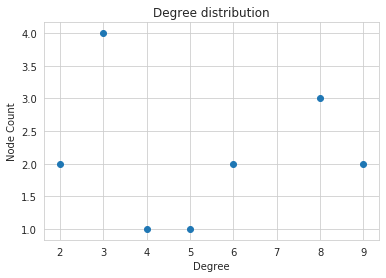

Community 0
L <= L_random? 0.9959230454359395 <= 1.2081375358166189
C >> C_random? 0.6515648285843232 >> 0.042248500125487955
Community 1
L <= L_random? 1.2227360287778972 <= 1.0424271772331073
C >> C_random? 0.5872396682615751 >> 0.06369430674518677
Community 2
L <= L_random? 0.911213162908015 <= 0.912250827470972
C >> C_random? 0.5857055710752618 >> 0.17897660159003023
Community 3
L <= L_random? 0.9405351884343481 <= 0.9423359087224633
C >> C_random? 0.6228781967318613 >> 0.11809130749536037
Community 4
L <= L_random? 0.9712590570198467 <= 1.0379887290419685
C >> C_random? 0.5161868723957441 >> 0.059025053699228336
Community 5
L <= L_random? 1.143544049070258 <= 0.9454054681604458
C >> C_random? 0.5639598311083167 >> 0.11889139450473588
Community 6
L <= L_random? 1.5250121124031009 <= 0.9934593023255814
C >> C_random? 0.6500929125748472 >> 0.12009683486967655
Community 7
L <= L_random? 0.9856216389329988 <= 1.2532426373450407
C >> C_random? 0.6245840479333703 >> 0.03132664708021641
C

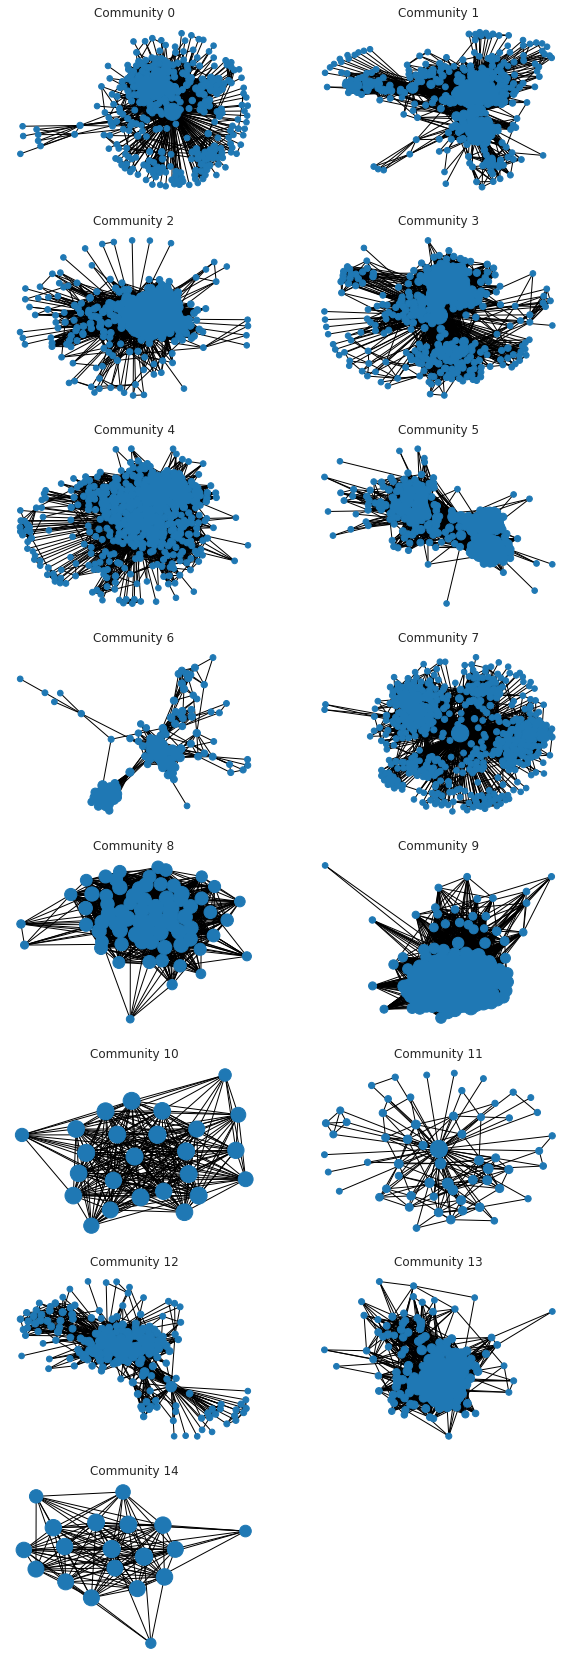

In [4]:
extract_communities(facebook, 1, True)